## Linear Regression Assignment
### Multiple Linear Regression - Bike Sharing

### Approach
- EDA
- Data Preparation
    - Creation of dummy variables
- Create train and test data
    - Scale
    - Check correlation
- Build Model
    - Use RFE initially
    - Check p-value and VIF
    - drop variables accordingly
    - finalize model
- Residual Analysis
- Makign Predictions
- Print R2 Score

In [1]:
## Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
bikeshare = pd.read_csv('day.csv')
bikeshare.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# Check data from cleaning aspect
bikeshare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### Observation : No null values

In [4]:
# Remove unwanted column(s)
# "instant" and "dteday" columns are not required for analysis
# "casual" and "registered" are redundant since we have "cnt" which is "casual + registered", and will show high correlation at
# later stage, hence dropping them as well
# "temp" is also redundant variable as we have "atemp" as well
bikeshare = bikeshare.drop(['instant','dteday','casual','registered','temp'],axis=1)
bikeshare.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,11.46350,43.6957,12.522300,1600


In [5]:
bikeshare.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,42.044800,97.250000,34.000021,8714.000000


In [6]:
#identifying numerical and categorical variables for analysis
numeric_vars = ["yr","holiday","workingday","atemp","hum","windspeed","cnt"]
categorical_vars = ['season', 'mnth', 'weekday', 'weathersit']

### Visualize Data To Understand Linearity

<Figure size 1440x1440 with 0 Axes>

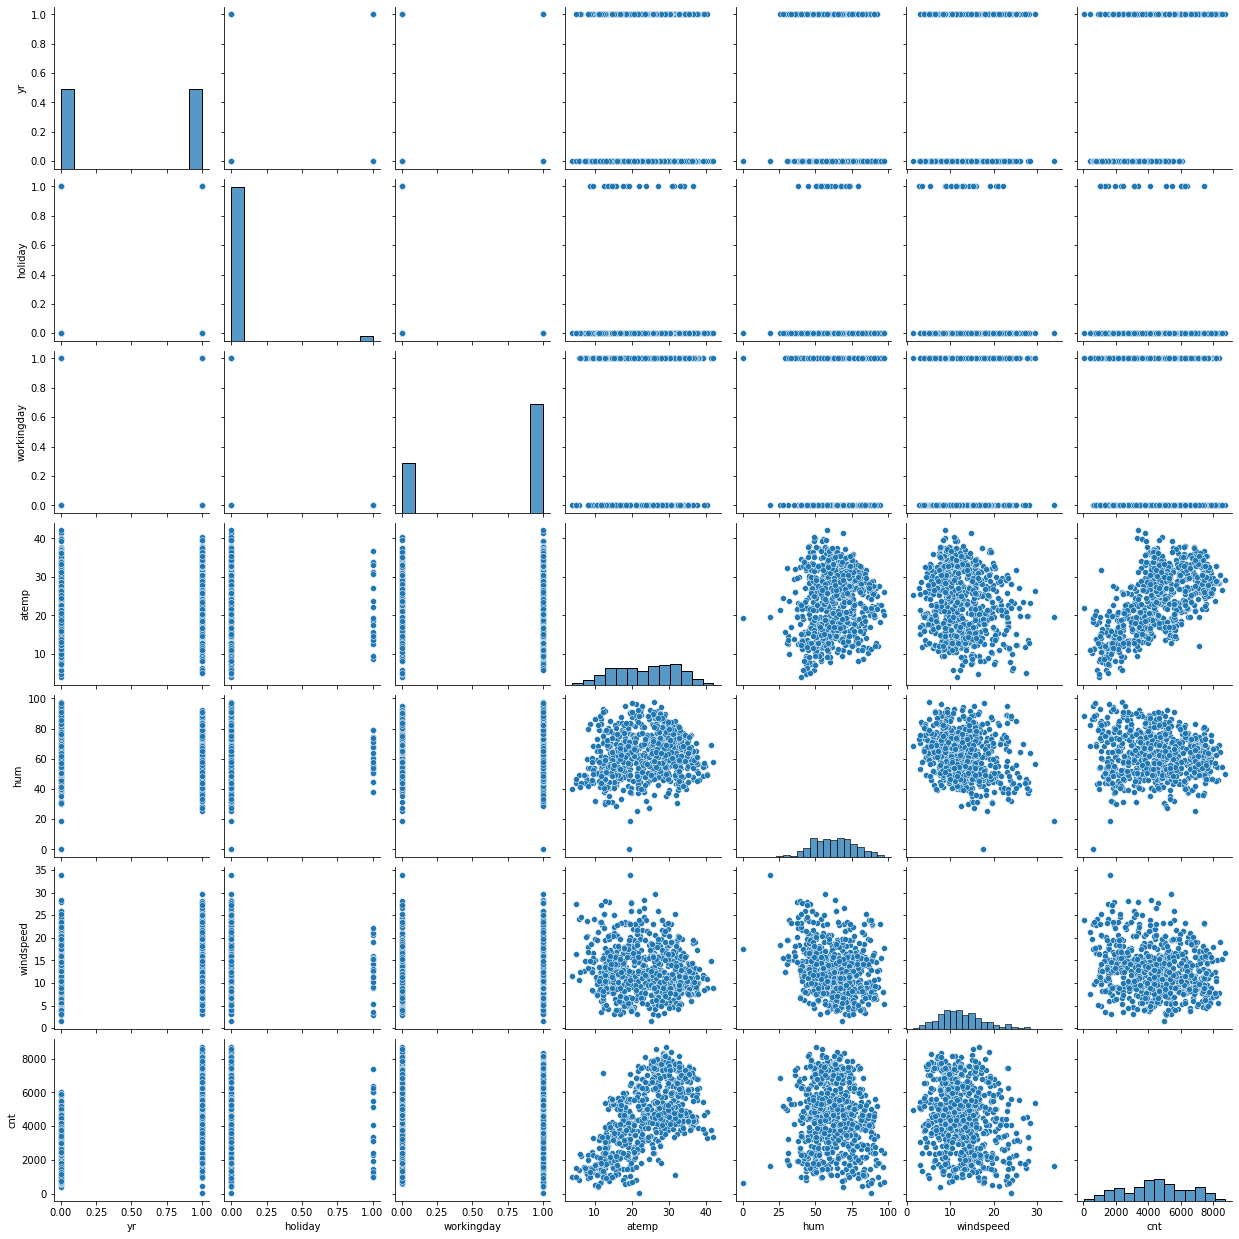

In [7]:
plt.figure(figsize=(20, 20))
sns.pairplot(bikeshare[numeric_vars])
plt.show()

#### Observation : "atemp" is showing some linearity w.r.t. "cnt"

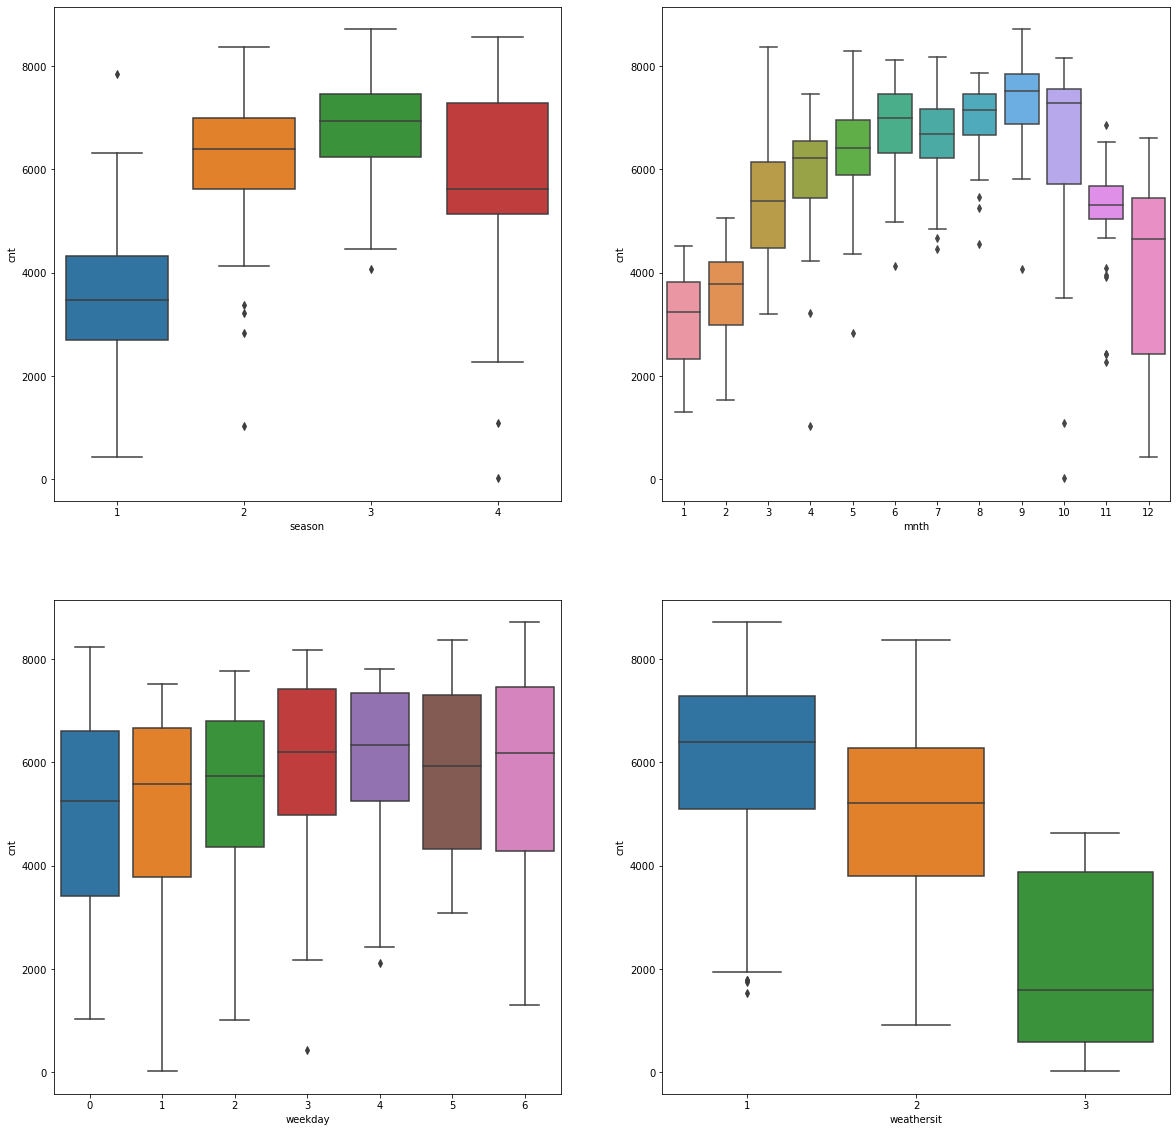

In [8]:
# Review categorical variables
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(x='season',y='cnt',data=bikeshare[bikeshare['yr']==1])
plt.subplot(2,2,2)
sns.boxplot(x='mnth',y='cnt',data=bikeshare[bikeshare['yr']==1])
plt.subplot(2,2,3)
sns.boxplot(x='weekday',y='cnt',data=bikeshare[bikeshare['yr']==1])
plt.subplot(2,2,4)
sns.boxplot(x='weathersit',y='cnt',data=bikeshare[bikeshare['yr']==1])
plt.show()

## Data Preparation
- Create dummy variables for categorical variables
- Since the values are in 1, 2, 3 format, we will rename the columns appropriately

In [9]:
season = pd.get_dummies(bikeshare['season'],drop_first = True)
print(season.columns)
season.columns = ['season_2', 'season_3', 'season_4']
season.head()

Int64Index([2, 3, 4], dtype='int64')


,season_2,season_3,season_4
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [10]:
month = pd.get_dummies(bikeshare['mnth'],drop_first = True)
month.columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month.head()

,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


In [11]:
weekday = pd.get_dummies(bikeshare['weekday'],drop_first = True)
weekday.columns = ['Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']
weekday.head()

,Mon,Tues,Wed,Thu,Fri,Sat
0,0,0,0,0,0,1
1,0,0,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,0,1,0,0,0


In [12]:
weather_situation = pd.get_dummies(bikeshare['weathersit'],drop_first = True)
weather_situation.columns = ['weathersit_2', 'weathersit_3']
weather_situation.head()

,weathersit_2,weathersit_3
0,1,0
1,1,0
2,0,0
3,0,0
4,0,0


In [13]:
bikeshare = pd.concat([bikeshare, season, month, weekday, weather_situation], axis = 1)

In [14]:
bikeshare.drop(categorical_vars, axis = 1, inplace = True)
bikeshare.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_2,season_3,season_4,...,Nov,Dec,Mon,Tues,Wed,Thu,Fri,Sat,weathersit_2,weathersit_3
0,0,0,0,18.18125,80.5833,10.749882,985,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,17.68695,69.6087,16.652113,801,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,9.47025,43.7273,16.636703,1349,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,10.60610,59.0435,10.739832,1562,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,11.46350,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Split Data To Create Train and Test Data

In [15]:
np.random.seed(0)
df_train, df_test = train_test_split(bikeshare, train_size = 0.7, test_size = 0.3, random_state = 100)

### Scaling
- Since variables have different scales/value range, we will bring them down to one scale of 0-1
- We will use min-max scaling, since we want all values in dataset to be in range of 0-1
- we will perform scaling on following variables - atemp, hum, windspeed, cnt. Rest others are already in range of 0-1
- we will perform scaling on training dataset only as we do not want to consider the test data for fitting

In [16]:
scaler = MinMaxScaler()

In [17]:
scale_vars = ['atemp', 'hum', 'windspeed', 'cnt']

df_train[scale_vars] = scaler.fit_transform(df_train[scale_vars])

In [18]:
df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_2,season_3,season_4,...,Nov,Dec,Mon,Tues,Wed,Thu,Fri,Sat,weathersit_2,weathersit_3
653,1,0,1,0.501133,0.575354,0.300794,0.864243,0,0,1,...,0,0,0,1,0,0,0,0,0,0
576,1,0,1,0.766351,0.725633,0.264686,0.827658,0,1,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.438975,0.640189,0.255342,0.465255,0,0,0,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.200348,0.498067,0.663106,0.204096,0,0,0,...,0,1,0,0,0,0,0,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,0.482973,1,0,0,...,0,0,0,0,0,0,0,1,1,0


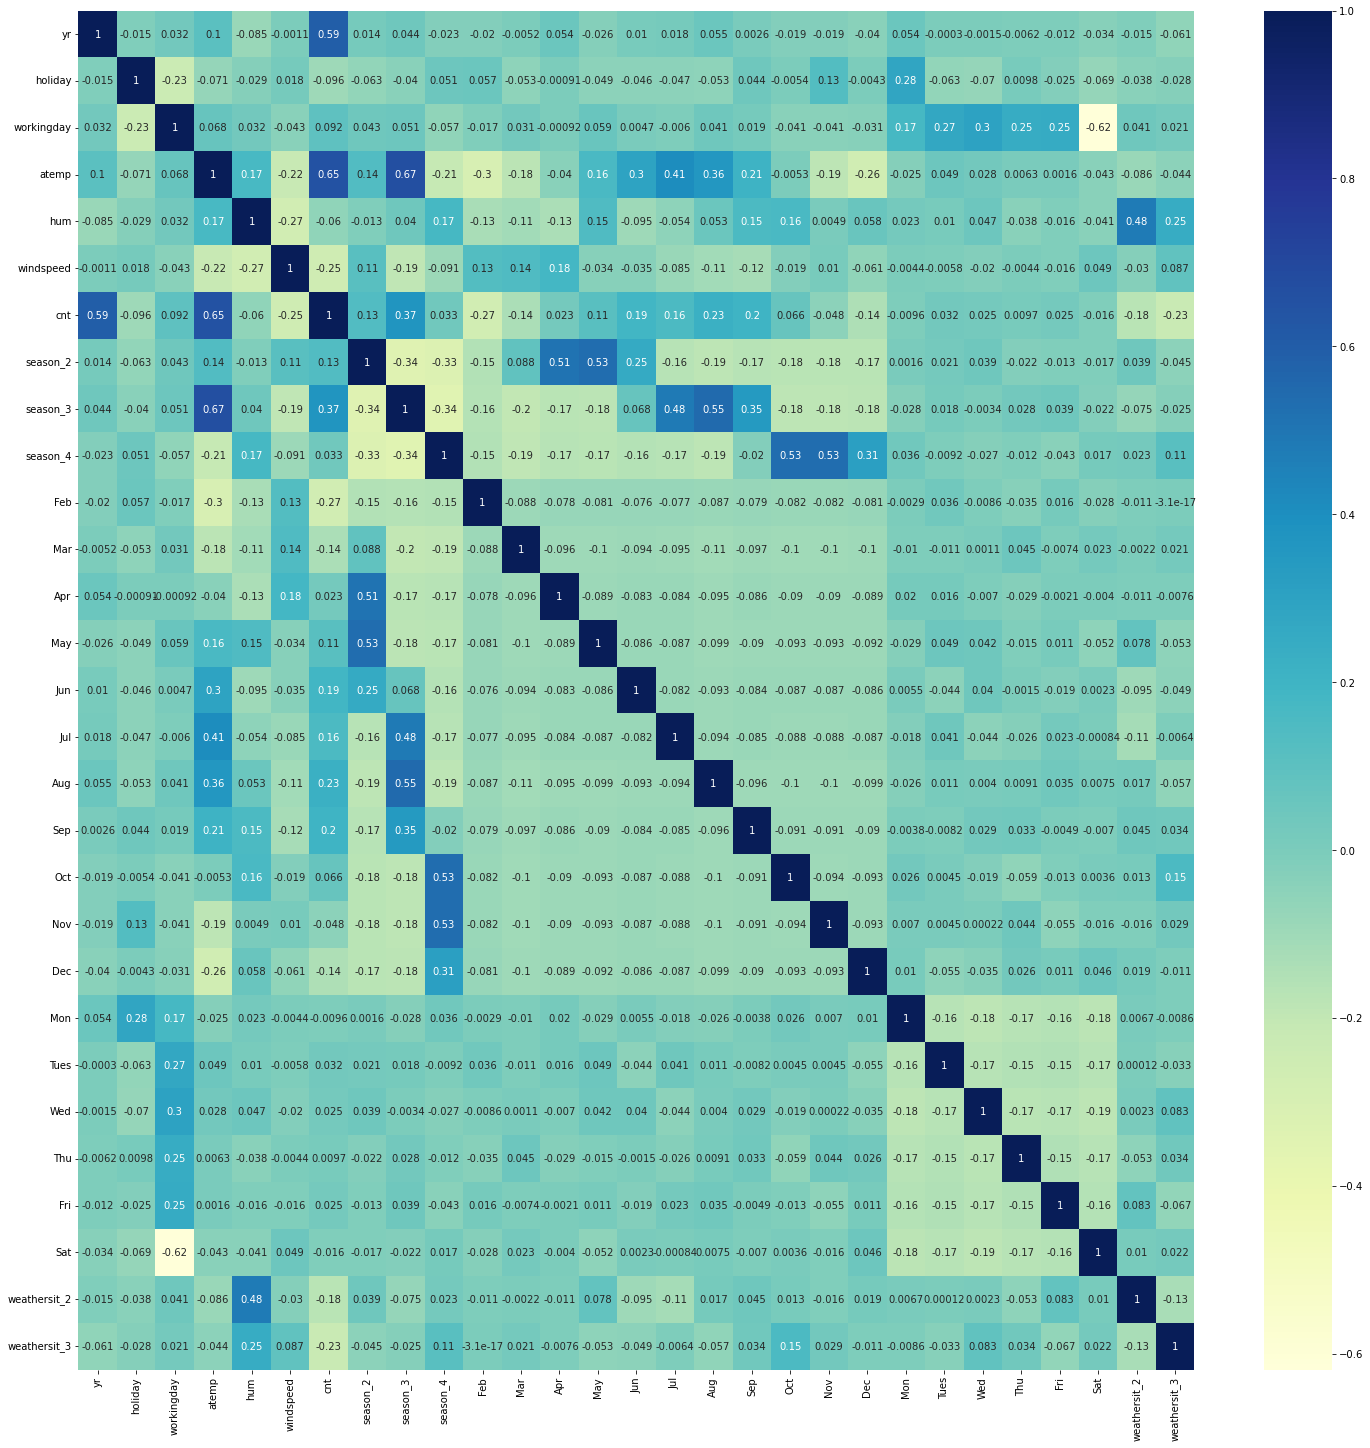

In [19]:
plt.figure(figsize = (25, 25))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### Observations : 
- Target variable "cnt" has good correlation with "yr", "atemp" and "season_3"
- The "windspeed" and "Feb" month has moderate negative correlation 
- There are few variables which has very weak (below 5%) correlation with "cnt", we will consider the count of such variables while doing RFE

### Builing Model
 - Setting up X train and y train

In [20]:
y_train = df_train.pop('cnt')
X_train = df_train

In [21]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [22]:
# we have 29 variables, we will consider top 15 features for the model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('Feb', False, 7),
 ('Mar', False, 3),
 ('Apr', False, 5),
 ('May', False, 2),
 ('Jun', False, 4),
 ('Jul', False, 6),
 ('Aug', True, 1),
 ('Sep', True, 1),
 ('Oct', True, 1),
 ('Nov', False, 11),
 ('Dec', False, 14),
 ('Mon', False, 8),
 ('Tues', False, 9),
 ('Wed', False, 12),
 ('Thu', False, 13),
 ('Fri', False, 10),
 ('Sat', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

In [23]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'Aug', 'Sep', 'Oct', 'Sat', 'weathersit_2',
       'weathersit_3'],
      dtype='object')

In [24]:
X_train_rfe = X_train[col]

In [25]:
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.5
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          8.04e-189
Time:                        11:55:58   Log-Likelihood:                 513.81
No. Observations:                 510   AIC:                            -995.6
Df Residuals:                     494   BIC:                            -927.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1938      0.029      6.658   

#### Observation : "holiday" has very high p-value denoting less significance

In [26]:
X_train_new = X_train_rfe.drop(["holiday"], axis = 1)

In [27]:
# rebuild the model
X_train_new = sm.add_constant(X_train_new)
X_train_new.head()
lm = sm.OLS(y_train,X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     191.1
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          3.18e-189
Time:                        11:55:58   Log-Likelihood:                 512.03
No. Observations:                 510   AIC:                            -994.1
Df Residuals:                     495   BIC:                            -930.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1849      0.029      6.423   

#### Observation : season_3 has higher p-value, however we should check first on the multi-collinearity 

In [28]:
## let's run the VIF and decide on which variable to drop
X_train_new = X_train_new.drop(['const'], axis=1)
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,22.70
3,hum,17.30
6,season_3,7.66
1,workingday,4.56
4,windspeed,3.79
5,season_2,3.36
7,season_4,2.88
12,weathersit_2,2.14
0,yr,2.04
8,Aug,1.86


In [29]:
# atemp has hight VIF value so let's drop it
X_train_new = X_train_new.drop(["atemp"], axis = 1)

In [30]:
## re-build the model
X_train_new = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     135.6
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          7.68e-154
Time:                        11:55:58   Log-Likelihood:                 425.06
No. Observations:                 510   AIC:                            -822.1
Df Residuals:                     496   BIC:                            -762.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2554      0.034      7.603   

In [31]:
## "hum" variable has high p-value, we will remove it now
X_train_new = X_train_new.drop(["hum"], axis = 1)

In [32]:
## rebuild the model
X_train_new = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     147.0
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          8.03e-155
Time:                        11:55:58   Log-Likelihood:                 424.79
No. Observations:                 510   AIC:                            -823.6
Df Residuals:                     497   BIC:                            -768.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2352      0.019     12.625   

In [33]:
## "Aug" variable has high p-value, we will remove it now
X_train_new = X_train_new.drop(["Aug"], axis = 1)

In [34]:
## rebuild the model
X_train_new = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_new).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     159.0
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          4.56e-155
Time:                        11:55:58   Log-Likelihood:                 422.73
No. Observations:                 510   AIC:                            -821.5
Df Residuals:                     498   BIC:                            -770.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2337      0.019     12.515   

#### Observations 
- The model looks good as all the variables we selected are highly significant
- The R-squared value also looks good 78%
- The probability of F-Stat is also very small means the model will fit

Now we will check the VIF and conclude on our model

In [35]:
## let's run the VIF and conclude on this model if the VIF for all is less than 5
X_train_new = X_train_new.drop(['const'], axis=1)
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,workingday,3.64
2,windspeed,3.27
5,season_4,2.21
4,season_3,1.96
0,yr,1.94
3,season_2,1.76
8,Sat,1.61
7,Oct,1.57
9,weathersit_2,1.53
6,Sep,1.28


#### Observation : All the VIF value are <5 so will now we move ahead and do the residual analysis

### Residual Analysis

In [36]:
X_train_lm = sm.add_constant(X_train_new)
lm = sm.OLS(y_train,X_train_lm).fit()
y_train_price = lm.predict(X_train_lm)

Text(0.5, 0, 'Errors')

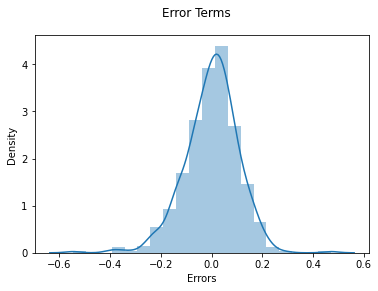

In [37]:
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms')
plt.xlabel('Errors')

#### Observation : The error distribution is normal. The model looks good.

### Making Predictions

In [38]:
# We will apply scaling (without fit) on test data set
df_test[scale_vars] = scaler.transform(df_test[scale_vars])

In [39]:
# setup X and y data sets
y_test = df_test.pop('cnt')
X_test = df_test

In [40]:
## we will setup the X test dataset with same columns we used in final model for X train data set
X_test_new = X_test[X_train_new.columns]

In [41]:
# making prediction
X_test_new = sm.add_constant(X_test_new)
y_pred = lm.predict(X_test_new)

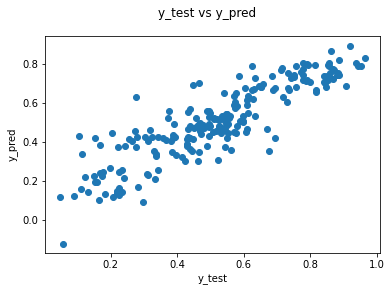

In [42]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()


In [43]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7714935069822348